In [7]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score , roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GINConv
from torch_geometric.nn import GatedGraphConv, Linear
from torch.nn import Linear, Sequential, ReLU
import torch.nn.functional as F



In [8]:
# protein-protein interactions of yeast
ppi_df = pd.read_csv("4932.protein.links.v12.0.csv")

# essential proteins of yeast (Gene essentiality was defined as genes that were either inviable upon deletion or annotated as essential in the YDP database.)
# Note: Due to the lack of a stable download option in the DEG database, essential gene labels were obtained from below Database .
labels_raw = pd.read_excel("pcbi.1008730.s008.xlsx",header=2)
gene_col = labels_raw.columns[0]

print(labels_raw.columns)

labels_raw["essentiality"] = (
    (labels_raw["inviable"] == 1) |
    (labels_raw["YDP essential"] == 1)
).astype(int)

labels_df = labels_raw[[gene_col, "essentiality"]]
labels_df.columns = ["protein_id", "essentiality"]
label_dict = dict(zip(labels_df["protein_id"], labels_df["essentiality"]))

print(labels_df.head())


Index(['Gene', 'Name', 'Gene description', 'Assigned class ', 'Unnamed: 4',
       'YDP essential', 'inviable', 'auxotroph', 'aerobic defective',
       'anaerobic defective', 'Comment', 'SGD Phenotype description'],
      dtype='object')
  protein_id  essentiality
0        NaN             0
1    YDL205C             1
2    YDR232W             1
3    YDR376W             1
4    YGL001C             1


In [9]:
ppi_df = ppi_df[ppi_df["combined_score"] >= 700] # consider high confidence interactions

ppi_df['protein1']=ppi_df['protein1'].str.split('.').str[1]  # in the PPI dataset proteins are determined with phrases like 4932.Q0010. we must eliminate 4932 and keep only the protein ID. these two lines do this.
ppi_df['protein2']=ppi_df['protein2'].str.split('.').str[1]

In [10]:
G = nx.Graph()
edges = list(zip(ppi_df["protein1"], ppi_df["protein2"]))
G.add_edges_from(edges)

G.remove_edges_from(nx.selfloop_edges(G)) # if you comment this line and run cells, you figure out that this dataset do not have self loop

print(f"PPI Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
# print(G.nodes())


PPI Graph: 5791 nodes, 104188 edges


In [11]:
# we only consider nodes of PPI network which we have their labels (we know their essentiality)
common_nodes = set(G.nodes()).intersection(label_dict.keys())
G = G.subgraph(common_nodes).copy()

print('We know labels of ',G.number_of_nodes(),' nodes.')
print('So we have ',G.number_of_edges(),' edges.')

We know labels of  887  nodes.
So we have  8356  edges.


In [12]:
G.remove_nodes_from(list(nx.isolates(G)))
print('Number of nodes after deleting isolated nodes is ',G.number_of_nodes()) # we do not have isolated nodes


Number of nodes after deleting isolated nodes is  857


In [13]:
print("Labeled graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

Labeled graph: 857 nodes, 8356 edges


In [14]:
y = np.array([label_dict[n] for n in G.nodes()])
print("Essential ratio:", y.mean())
print(y)


Essential ratio: 0.17269544924154026
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

In [15]:
degree_feature = np.array([G.degree(n) for n in G.nodes()])

clust = nx.clustering(G)
clustering_coeff_feature = np.array([clust[n] for n in G.nodes()])

core = nx.core_number(G)
core_number_feature = np.array([core[n] for n in G.nodes()])

X = np.vstack([degree_feature, clustering_coeff_feature, core_number_feature]).T
X = StandardScaler().fit_transform(X)

node2id = {n: i for i, n in enumerate(G.nodes())}
id2node = {i: n for n, i in node2id.items()}

edge_index = []

for u, v in G.edges():
    edge_index.append([node2id[u], node2id[v]])
    edge_index.append([node2id[v], node2id[u]])

edge_index = np.array(edge_index).T


In [16]:
print("Final Dataset Summary")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("edge_index shape:", edge_index.shape)
print("Essential ratio:", y.mean())


Final Dataset Summary
X shape: (857, 3)
y shape: (857,)
edge_index shape: (2, 16712)
Essential ratio: 0.17269544924154026


In [17]:
# classical approachs of predicting essential proteins
centrality_scores = {
    "degree": nx.degree_centrality(G),
    "pagerank": nx.pagerank(G),
    "eigenvector": nx.eigenvector_centrality(G, max_iter=500),
    "closeness": nx.closeness_centrality(G),
    "betweenness": nx.betweenness_centrality(G, k=100, seed=42)
}

cent_df = pd.DataFrame({
    name: [scores[n] for n in G.nodes()]
    for name, scores in centrality_scores.items()
})


cent_df["y"] = y



# random walk with restart
def build_transition_matrix(G, node2id):
    n = len(node2id)
    W = np.zeros((n, n))

    for u, v in G.edges():
        i, j = node2id[u], node2id[v]
        W[j, i] = 1
        W[i, j] = 1

    # column-normalize
    col_sum = W.sum(axis=0)
    col_sum[col_sum == 0] = 1
    W = W / col_sum

    return W


def random_walk_with_restart(G, node2id, restart_prob=0.3, max_iter=100, tol=1e-6):
    n = len(node2id)
    W = build_transition_matrix(G, node2id)

    # uniform start (unsupervised)
    p0 = np.ones(n) / n
    p = p0.copy()

    for _ in range(max_iter):
        p_new = (1 - restart_prob) * (W @ p) + restart_prob * p0
        if np.linalg.norm(p_new - p, 1) < tol:
            break
        p = p_new

    return p

# Random Walk with Restart was used as a classical graph-based baseline to capture both local and global topological importance. 
# The restart mechanism biases the random walk toward the starting distribution, preventing excessive diffusion and enabling the 
# identification of proteins located in dense and functionally relevant interaction neighborhoods.



In [ ]:
def eval_classification(scores, y, thr=None):
    if thr is None:
        thr = np.percentile(scores, 100 * (1 - y.mean())) # why did we compute threshold this way? explain it
    y_pred = (scores >= thr).astype(int)
    return {
        "AUC": roc_auc_score(y, scores),
        "F1": f1_score(y, y_pred)
    }

for c in centrality_scores:
    res = eval_classification(cent_df[c].values, y)
    print(c, res)


# RWR evaluation
rwr_scores = random_walk_with_restart(G, node2id, restart_prob=0.3)
auc = roc_auc_score(y, rwr_scores)
thr = np.percentile(rwr_scores, 100 * (1 - y.mean()))
f1 = f1_score(y, rwr_scores >= thr)

print("RWR AUC:", auc)
print("RWR F1:", f1)


print()


def precision_at_k(scores, y, k=100):     # this metric determines that if we are only allowed to propose K genes/proteins as essential, what percentage of them are actually essential?
    idx = np.argsort(scores)[::-1][:k]    # Precision@100 was used to evaluate the ranking quality of each method, measuring the fraction of truly essential proteins among the top 100 highest-scoring candidates.
    return y[idx].sum() / k

for c in centrality_scores:
    p_at_k = precision_at_k(cent_df[c].values, y, k=100)
    print(f"{c} Precision@100:", p_at_k)


p100 = precision_at_k(rwr_scores, y, k=100)
print("RWR Precision@100:", p100)


# Note: We evaluated all methods using both classification and ranking metrics. Classification performance was
#  measured using AUC-ROC and F1-score on a held-out test set. Ranking quality was assessed using Precision@100,
#  reflecting the practical scenario of prioritizing a limited number of candidate essential proteins.

degree {'AUC': np.float64(0.5622879579156025), 'F1': np.float64(0.18241042345276873)}
pagerank {'AUC': np.float64(0.5842116799451074), 'F1': np.float64(0.19594594594594594)}
eigenvector {'AUC': np.float64(0.47409274577821825), 'F1': np.float64(0.11486486486486487)}
closeness {'AUC': np.float64(0.5198271261388328), 'F1': np.float64(0.10810810810810811)}
betweenness {'AUC': np.float64(0.5955857126520032), 'F1': np.float64(0.22972972972972974)}
RWR AUC: 0.5896247093355698
RWR F1: 0.1891891891891892
degree Precision@100: 0.13
pagerank Precision@100: 0.15
eigenvector Precision@100: 0.14
closeness Precision@100: 0.13
betweenness Precision@100: 0.25
RWR Precision@100: 0.2


In [19]:
# GNNs

# data preparation 
data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    y=torch.tensor(y, dtype=torch.long)
)

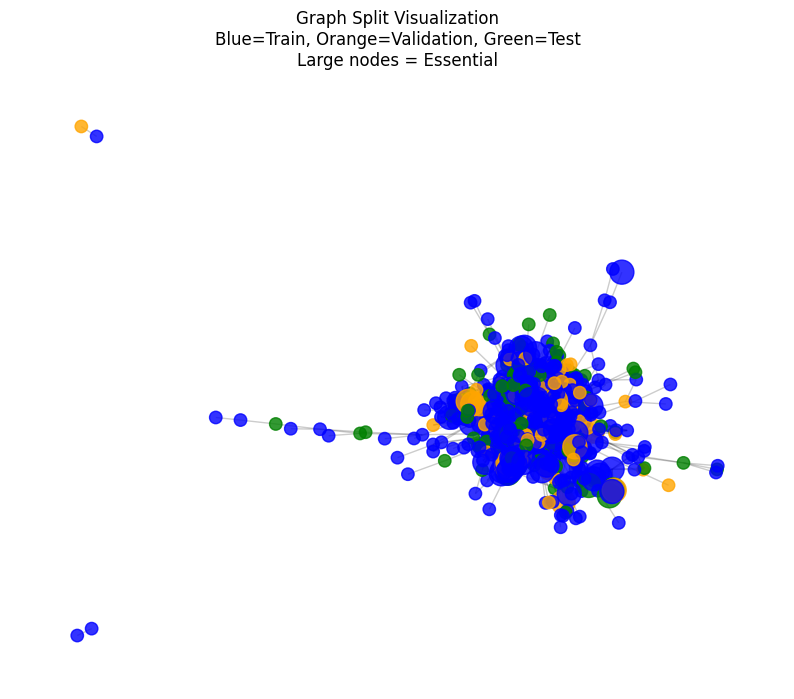

In [20]:
# split data to the train-validation-test sets

idx = np.arange(len(y))

train_idx, test_idx = train_test_split(
    idx, test_size=0.15, stratify=y, random_state=42  # stratified sampling causes the ratio of classes (essential / non-essential) in train and test be approximately equal to the ratio of the entire dataset.
)

train_idx, val_idx = train_test_split(
    train_idx, test_size=0.176, stratify=y[train_idx], random_state=42
)
# Training, validation, and test nodes were specified using boolean masks over a single graph, following the standard practice in node classification with graph neural networks.
def make_mask(idx, n):
    m = torch.zeros(n, dtype=torch.bool)
    m[idx] = True
    return m

data.train_mask = make_mask(train_idx, len(y))
data.val_mask   = make_mask(val_idx, len(y))
data.test_mask  = make_mask(test_idx, len(y))


# Due to strong dependencies between nodes in the PPI network, standard k-fold cross-validation can introduce information leakage. 
# Therefore, if we want we can use stratified random splits and report average performance over multiple runs. (in graphs we can use Subgraph CV or Repeated random split instead of K-fold CV)


pos = nx.spring_layout(G, seed=42)

node_colors = []
node_shapes = []

for i in range(len(data.y)):
    if data.train_mask[i]:
        node_colors.append("blue")
    elif data.val_mask[i]:
        node_colors.append("orange")
    else:
        node_colors.append("green")

# essential vs non-essential overlay
sizes = np.where(data.y.cpu().numpy() == 1, 300, 80)

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=sizes,
    alpha=0.8
)

plt.title(
    "Graph Split Visualization\n"
    "Blue=Train, Orange=Validation, Green=Test\n"
    "Large nodes = Essential"
)
plt.axis("off")
plt.show()

In [21]:
# GCN

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.c1 = GCNConv(in_dim, hid)
        self.c2 = GCNConv(hid, hid)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.c1(x, edge_index))
        x = F.relu(self.c2(x, edge_index))
        return self.out(x).view(-1)



In [22]:
# GraphSAGE

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.c1 = SAGEConv(in_dim, hid)
        self.c2 = SAGEConv(hid, hid)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.c1(x, edge_index))
        x = F.relu(self.c2(x, edge_index))
        return self.out(x).view(-1)

In [23]:
# GATv2

class GATv2(torch.nn.Module):
    def __init__(self, in_dim, hid=64, heads=4):
        super().__init__()
        self.c1 = GATv2Conv(in_dim, hid, heads=heads)
        self.c2 = GATv2Conv(hid * heads, hid, heads=1)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = F.elu(self.c1(x, edge_index))
        x = F.elu(self.c2(x, edge_index))
        return self.out(x).view(-1)


In [24]:
# GIN

class GIN(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        nn1 = torch.nn.Sequential(Linear(in_dim, hid), torch.nn.ReLU())
        nn2 = torch.nn.Sequential(Linear(hid, hid), torch.nn.ReLU())
        self.c1 = GINConv(nn1)
        self.c2 = GINConv(nn2)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = self.c1(x, edge_index)
        x = self.c2(x, edge_index)
        return self.out(x).view(-1)


In [25]:
# GatedGCN

class GatedGCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim=64, num_layers=3):
        super().__init__()

        self.input_proj = Linear(in_dim, hid_dim)

        self.gated_conv = GatedGraphConv(
            out_channels=hid_dim,
            num_layers=num_layers
        )

        self.output_proj = Linear(hid_dim, 1)

    def forward(self, x, edge_index):
        x = self.input_proj(x)
        x = self.gated_conv(x, edge_index)
        return self.output_proj(x).view(-1)

In [26]:
# All GNN architectures were intentionally kept shallow to ensure fair comparison with classical graph-based methods and to 
# mitigate overfitting and oversmoothing effects in the relatively small and dense PPI network.

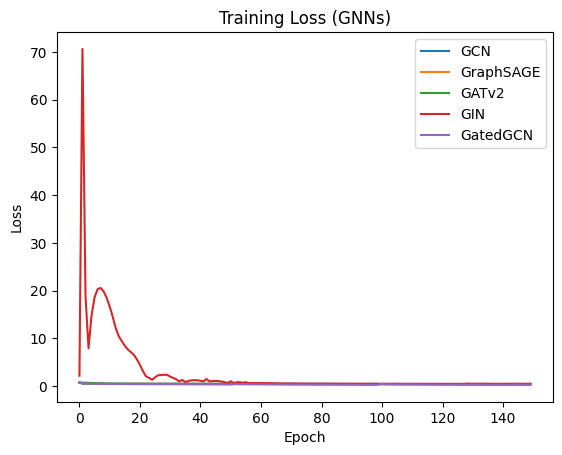

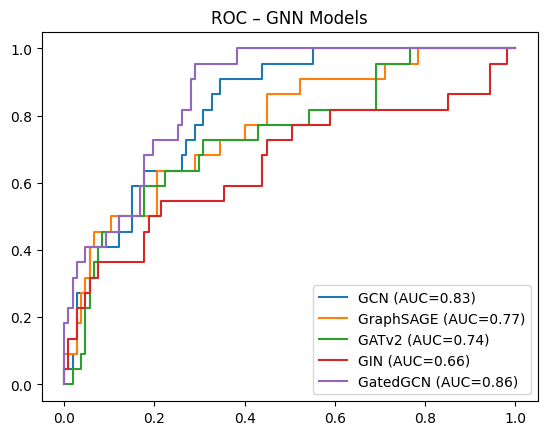

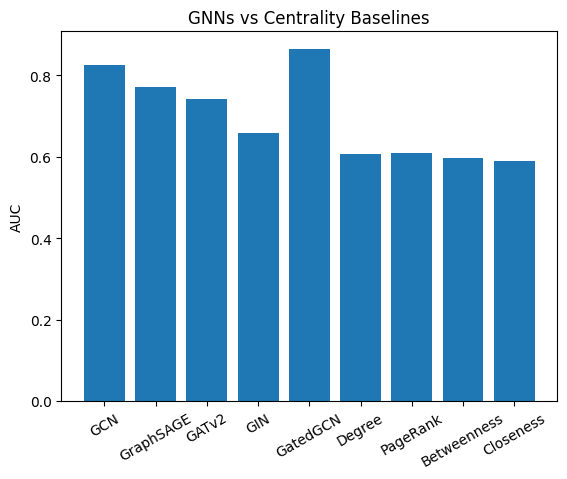

In [27]:
# GNNs train & evaluation
def train_model(model, data, epochs=150):
    opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    losses = []

    for _ in range(epochs):
        model.train()
        opt.zero_grad()
        logits = model(data.x, data.edge_index)
        loss = F.binary_cross_entropy_with_logits(
            logits[data.train_mask],
            data.y[data.train_mask].float()
        )
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return losses



@torch.no_grad()
def evaluate_model(model, data):
    model.eval()
    scores = torch.sigmoid(model(data.x, data.edge_index)).cpu().numpy()
    y_true = data.y.cpu().numpy()

    return {
        "scores": scores,
        "auc": roc_auc_score(y_true[data.test_mask], scores[data.test_mask]),
        "f1": f1_score(y_true[data.test_mask], scores[data.test_mask] > 0.5)
    }



models = {
    "GCN": GCN(data.x.shape[1]),
    "GraphSAGE": GraphSAGE(data.x.shape[1]),
    "GATv2": GATv2(data.x.shape[1]),
    "GIN": GIN(data.x.shape[1]),
    "GatedGCN": GatedGCN(data.x.shape[1])
}

results, loss_curves = {}, {}

for name, model in models.items():
    loss_curves[name] = train_model(model, data)
    results[name] = evaluate_model(model, data)




centrality_scores = {
    "Degree": np.array(list(nx.degree_centrality(G).values())),
    "PageRank": np.array(list(nx.pagerank(G).values())),
    "Betweenness": np.array(list(nx.betweenness_centrality(G).values())),
    "Closeness": np.array(list(nx.closeness_centrality(G).values()))
}

centrality_auc = {
    k: roc_auc_score(data.y[data.test_mask], v[data.test_mask])
    for k, v in centrality_scores.items()
}




# plot of training loss
plt.figure()
for k, v in loss_curves.items():
    plt.plot(v, label=k)
plt.title("Training Loss (GNNs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot of ROC curves (GNNs)
plt.figure()
for k, r in results.items():
    fpr, tpr, _ = roc_curve(
        data.y[data.test_mask], r["scores"][data.test_mask]
    )
    plt.plot(fpr, tpr, label=f"{k} (AUC={r['auc']:.2f})")
plt.title("ROC – GNN Models")
plt.legend()
plt.show()

# plot of GNN vs Centrality (AUC)
names = list(results.keys()) + list(centrality_auc.keys())
auc_vals = [results[m]["auc"] for m in results] + list(centrality_auc.values())

plt.figure()
plt.bar(names, auc_vals)
plt.xticks(rotation=30)
plt.ylabel("AUC")
plt.title("GNNs vs Centrality Baselines")
plt.show()